# Purchase Card Transactions - Anomaly Detection 

Birmingham City Council is the local government body responsible for the governance of the City of Birmingham in England. For them transparency is one of the main values they want to reflect and with open data initiatives they give access to be freely used, reused and redistributed by anyone. That's why they started publishing all corporate purchase of card transactions since Apr 2014 until date,  our main goal will be to audit through an unsupervised machine learning algorithm if there is any anomaly present in the information that is exposed. 

Anomaly detection is an important tool for detecting fraud, network intrusion or rare events that may have impact but are hard to identify. In this notebook we will use anomaly detection to finding patterns in data that don’t conform to a model of normal behavior for the corporate purchase of card (if any). 

We will use the Framework of Microsoft Team Data Science Process (TDSP) and the Data science steps for ML by Google to determine the lifecycle outlines the major stages this project, this will be: 
- Business Understanding
     - Define a problem
- Data Acquisition and Understanding
    - Data extraction
    - Data analysis
    - Data preparation
- Modeling
    - Model training
    - Model evaluation
- Deployment
In this notebook we will focus on the first three items and give some recommendations for the last item. 

In [3]:
# Importing Required Libraries 

# Web-Scrapping
from bs4 import BeautifulSoup
import urllib
import requests
import os 
from datetime import datetime, timedelta

# Data Analysis 
import pandas as pd
import numpy as np

# Visualization
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

#Config
pd.pandas.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Business Understanding
As we mentioned earlier our main objetive would be to identify anomalies in the transactions that ocurred with the corporate purchase of card for the Birmingham City Council what will happen if we detect anything anormal we will mail:  foi.mailbox@birmingham.gov.uk asking for additional information.

## Data Acquisition and Understanding
### Data Extraction
They gave us access to the [this url](https://data.birmingham.gov.uk/dataset/purchase-card-transactions) here we will find all the datasets from Apr 2014 to Jan 2018, we can then web scrap the page to obtain the distinct links and aftewards download all the related dataset, we could do it manually but it would take time each time we want to access the data, it will be harder to replicate our experiment and we would incur into a risk of downloading the information twice or skip a file. Each of the files we identify within the webpage we will then save it to our local (in case the later they change anything within their webpage or they restrict the access through webscrappers) and finally we will read each file and concatenate in a complete dataset before we start our data analysis.

In [2]:
url = 'https://data.birmingham.gov.uk/dataset/purchase-card-transactions'

def get_beutiful_content(url):
    url_request = requests.get(url)
    assert url_request.status_code == 200
    src = BeautifulSoup(url_request.content)
    return src

src = get_beutiful_content(url)
all_list = src.find_all('a', "resource-url-analytics")
all_xls = [tag['href'] for tag in all_list if tag['href'].find('.xls') != -1 or tag['href'].find('.csv') != -1]
print(all_xls[0],'\n',all_xls[-1])

https://data.birmingham.gov.uk/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/b4a15ade-11b1-4c98-88a0-8cd8408212ac/download/purchasecardtransactionsapril2014.xls 
 https://data.birmingham.gov.uk/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/200906b7-366c-441c-9071-ec9ab086e193/download/cusersfinainmndesktoppublish-spend-january-2018.xls


In [3]:
dates = ["2014-04-01", "2018-01-30"]

def create_month_year_list(dates):
    start, end = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    mlist = []
    total_months = lambda dt: dt.month + 12 * dt.year
    for tot_m in range(total_months(start)-1, total_months(end)):
        y, m = divmod(tot_m, 12)
        mlist.append(datetime(y, m+1, 1).strftime("%Y-%m"))
    return mlist

names_xls = create_month_year_list(dates)
names_xls.remove('2015-04') # this month is missing
assert len(names_xls) == len(all_xls)

In [4]:
path_to_save = "./data/"

def save_all_files_local(all_xls, path):
    
    for i, url_xls in enumerate(all_xls):

        file_format = url_xls[url_xls.rfind('.'):]
        save_name = path + names_xls[i] + file_format

        if file_format == '.csv':
            response = urllib.request.urlopen(url_xls)
            csv = response.read()
            with open(path + names_xls[i] + file_format, 'wb') as f:
                f.write(csv)
        else:
            urllib.request.urlretrieve(url_xls, save_name)

save_all_files_local(all_xls, path_to_save)

In [38]:
def get_dataset(data_path='./data/'):
    final_df = pd.DataFrame()
    local_list_xls = os.listdir(data_path) 
    for file in local_list_xls:
        if file.endswith('xls'):
            temp_df = pd.read_excel(data_path + file)
        if file.endswith('csv'):
            temp_df = pd.read_csv(data_path + file, sep=',')
        final_df = pd.concat([final_df, temp_df], axis=0, sort=True)
    return final_df

In [39]:
df = get_dataset()

### Data Analysis
#### Dataset general information 

The first thing we want to do is answer:
* What is the shape of the dataset?
* How many columns (features) are?
* What are the type of features?


In [40]:
print(f'Data shape: {df.shape} \n')
print(f'Information of data columns:{df.info()} \n')

Data shape: (186060, 29) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186060 entries, 0 to 5639
Data columns (total 29 columns):
AGENT                 151 non-null object
APPLICANT             151 non-null object
Accepted              151 non-null object
BILLING CUR CODE      88696 non-null object
BILLING CUR CODE.1    4598 non-null object
BILLING GROSS AMT     54229 non-null float64
CARD NUMBER           185908 non-null object
Category              151 non-null object
DEV                   151 non-null object
Directorate           169311 non-null object
Directorate           2062 non-null object
Directorates          9839 non-null object
LOCATION              151 non-null object
MERCHANT NAME         185908 non-null object
ORIGINAL CUR          54229 non-null object
ORIGINAL GROSS AMT    185908 non-null float64
REFERENCE             151 non-null object
Received_Date         151 non-null object
TRANS CAC CODE 1      185804 non-null object
TRANS CAC CODE 2      185673 non-null ob

From this we can get the sense of the total data set, we got around 186K samples and a total of 29 columns most of them are categorical and a few numerical and last but no least a datetime column. Also, we can see that the data set has some missing values, we will explore in more detail these missing values and determined what to do with them.

###### Exploring missing values

We will explore all the columns that have missing values, we want a nice clean dataset by the end of the exploration we will setup all the data transformations within a function.

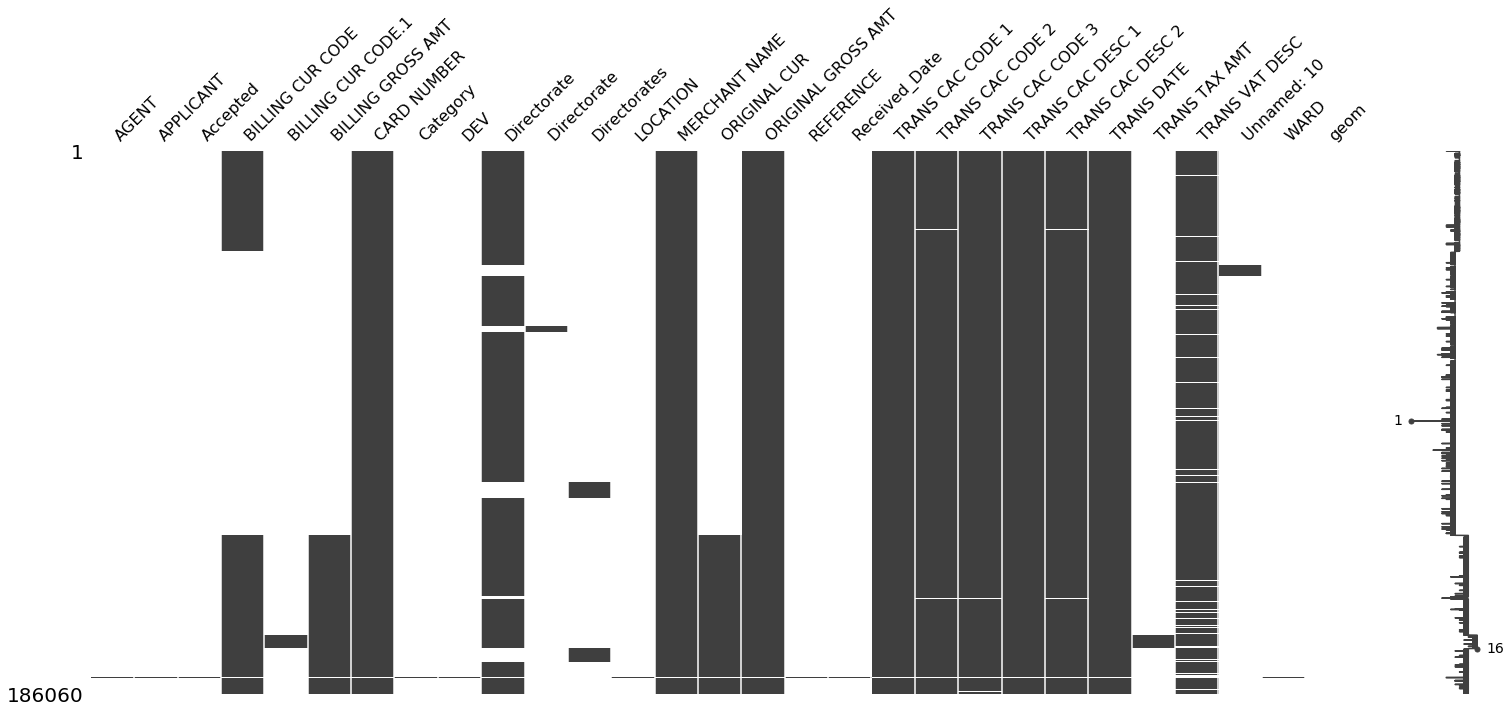

In [41]:
msno.matrix(df)

With Missingno library we can get a graphical sense about the missing values, here we can se that there are some variables which seem that we can transform only into 1 for example all the combination of Directorate, Directorate (with a space), Directorates and Unnamed:10.

Also we can see that there are varaibles that appear in all the datasets like the starting with TRANS_CAC, ORIGINAL GORSS AMT, MERCHANT NAME, CARD NUMBER and others that don't seem to report the same information from other (maybe the csv exception) like AGENT, WARD, GEOM. 

Let's then try to reduce to less columns for the features that are reported with a different name but are the same

In [42]:
df.sample(3)

AGENT APPLICANT Accepted BILLING CUR CODE BILLING CUR CODE.1  \
3046   NaN       NaN      NaN              NaN                NaN   
2038   NaN       NaN      NaN              NaN                NaN   
1126   NaN       NaN      NaN              GBP                NaN   

      BILLING GROSS AMT       CARD NUMBER Category  DEV     Directorate  \
3046                NaN  ************5900      NaN  NaN   CYP&F SCHOOLS   
2038                NaN  ************4340      NaN  NaN  Local Services   
1126               56.0  ************0124      NaN  NaN             NaN   

     Directorate    Directorates LOCATION          MERCHANT NAME ORIGINAL CUR  \
3046          NaN            NaN      NaN  parcelforce worldwide          NaN   
2038          NaN            NaN      NaN         greggs - s1873          NaN   
1126          NaN  CYP&F SCHOOLS      NaN      www.staples.co.uk          GBP   

      ORIGINAL GROSS AMT REFERENCE Received_Date TRANS CAC CODE 1  \
3046               12.98       NaN           NaN             MC70   
2038                6.20       NaN           NaN             L220   
1126               56.00       NaN           NaN             L420   

     TRANS CAC CODE 2 TRANS CAC CODE 3    TRANS CAC DESC 1  \
3046            REAFZ              A00  Supplies & Sev Mic   
2038            RUF0F              A00      Purchases Food   
1126            REAAB              A00          Stationery   

                            TRANS CAC DESC 2 TRANS DATE  TRANS TAX AMT  \
3046            Kings Norton Junior & Infant 2015-10-05            NaN   
2038  Illegal Money Lending T Stds Comm Inv. 2016-08-09            NaN   
1126           The City of Birmingham School 2017-10-11            NaN   

     TRANS VAT DESC Unnamed: 10 WARD  geom  
3046             VZ         NaN  NaN   NaN  
2038             VR         NaN  NaN   NaN  
1126             VR         NaN  NaN   NaN

In [43]:
df[~df['APPLICANT'].isna()].sample(3)
df[(~df['AGENT'].isna()) &(~df['ORIGINAL GROSS AMT'].isna())]
df[~df['APPLICANT'].isna()].sample(3)
df[(~df['APPLICANT'].isna()) &(~df['ORIGINAL GROSS AMT'].isna())]

AGENT  \
111  M Tufail, 269 Somerville Road, Small Heath, Bi...   
62   David Lock Associates, 50 North Thirteenth Str...   
66   Mr Tim Clegg, 1 Tivoli Copse, Woodside Avenue,...   

                                             APPLICANT    Accepted  \
111  Al Burhan Grammar School,Al-Burhan Grammar Sch...  16/01/2018   
62   Pebble Mill Investments Ltd,76 Hagley Road, Ed...  11/01/2018   
66   Mrs Shirley Clegg,13, Park Edge, Birmingham, B...  11/01/2018   

    BILLING CUR CODE BILLING CUR CODE.1  BILLING GROSS AMT CARD NUMBER  \
111              NaN                NaN                NaN         NaN   
62               NaN                NaN                NaN         NaN   
66               NaN                NaN                NaN         NaN   

                        Category  \
111                  Minor Other   
62   Determine Condition Details   
66                   Householder   

                                                   DEV Directorate  \
111  Erection of single storey side and front exten...         NaN   
62   Application to determine the details of condit...         NaN   
66   Erection of single storey rear extension and f...         NaN   

    Directorate  Directorates  \
111          NaN          NaN   
62           NaN          NaN   
66           NaN          NaN   

                                              LOCATION MERCHANT NAME  \
111  Al-Burhan Grammar School, 258 Spring Road, Spr...           NaN   
62   Former Harborne Lane Reservoir Site, Selly Oak...           NaN   
66                   13 Park Edge, Birmingham, B17 9ER           NaN   

    ORIGINAL CUR  ORIGINAL GROSS AMT      REFERENCE Received_Date  \
111          NaN                 NaN  2018/00246/PA    12/01/2018   
62           NaN                 NaN  2017/10671/PA    18/12/2017   
66           NaN                 NaN  2018/00077/PA    05/01/2018   

    TRANS CAC CODE 1 TRANS CAC CODE 2 TRANS CAC CODE 3 TRANS CAC DESC 1  \
111              NaN              NaN              NaN              NaN   
62               NaN              NaN              NaN              NaN   
66               NaN              NaN              NaN              NaN   

    TRANS CAC DESC 2 TRANS DATE  TRANS TAX AMT TRANS VAT DESC Unnamed: 10  \
111              NaN        NaT            NaN            NaN         NaN   
62               NaN        NaT            NaN            NaN         NaN   
66               NaN        NaT            NaN            NaN         NaN   

             WARD  geom  
111  Acocks Green   NaN  
62      Edgbaston   NaN  
66       Harborne   NaN

Empty DataFrame
Columns: [AGENT, APPLICANT, Accepted, BILLING CUR CODE, BILLING CUR CODE.1, BILLING GROSS AMT, CARD NUMBER, Category, DEV, Directorate, Directorate , Directorates, LOCATION, MERCHANT NAME, ORIGINAL CUR, ORIGINAL GROSS AMT, REFERENCE, Received_Date, TRANS CAC CODE 1, TRANS CAC CODE 2, TRANS CAC CODE 3, TRANS CAC DESC 1, TRANS CAC DESC 2, TRANS DATE, TRANS TAX AMT, TRANS VAT DESC, Unnamed: 10, WARD, geom]
Index: []

AGENT  \
33  Karl Grace Design Ltd, Woodlands Design Studio...   
58  RRDS Ltd, Studio 1 1st Floor, The Ffwrwm, High...   
30  Realys, 6th Floor, 40 Gracechurch Street, Lond...   

                                            APPLICANT    Accepted  \
33  Horton Motorcycles Ltd,24-28 Chester Road, Sut...  12/01/2018   
58  Iceland Foods Ltd,Second Avenue, Deeside Indus...  17/01/2018   
30  Barclays Bank Plc,Churchill Place, Canary Whar...  12/01/2018   

   BILLING CUR CODE BILLING CUR CODE.1  BILLING GROSS AMT CARD NUMBER  \
33              NaN                NaN                NaN         NaN   
58              NaN                NaN                NaN         NaN   
30              NaN                NaN                NaN         NaN   

         Category                                                DEV  \
33  Change of Use  Part change of use to include MOT testing faci...   
58   Minor Retail  Installation of additional new sections of sho...   
30    Minor Other  Installation of two air conditioning units to ...   

   Directorate Directorate  Directorates  \
33         NaN          NaN          NaN   
58         NaN          NaN          NaN   
30         NaN          NaN          NaN   

                                             LOCATION MERCHANT NAME  \
33  24-28 Chester Road, Sutton Coldfield, Birmingh...           NaN   
58  Unit 4 One Stop Shopping Centre, Walsall Road,...           NaN   
30  Barclays Bank Plc, 238 High Street, Erdington,...           NaN   

   ORIGINAL CUR  ORIGINAL GROSS AMT      REFERENCE Received_Date  \
33          NaN                 NaN  2017/10964/PA    27/12/2017   
58          NaN                 NaN  2018/00384/PA    17/01/2018   
30          NaN                 NaN  2017/10660/PA    15/12/2017   

   TRANS CAC CODE 1 TRANS CAC CODE 2 TRANS CAC CODE 3 TRANS CAC DESC 1  \
33              NaN              NaN              NaN              NaN   
58              NaN              NaN              NaN              NaN   
30              NaN              NaN              NaN              NaN   

   TRANS CAC DESC 2 TRANS DATE  TRANS TAX AMT TRANS VAT DESC Unnamed: 10  \
33              NaN        NaT            NaN            NaN         NaN   
58              NaN        NaT            NaN            NaN         NaN   
30              NaN        NaT            NaN            NaN         NaN   

            WARD  geom  
33  Sutton Vesey   NaN  
58    Perry Barr   NaN  
30     Erdington   NaN

Empty DataFrame
Columns: [AGENT, APPLICANT, Accepted, BILLING CUR CODE, BILLING CUR CODE.1, BILLING GROSS AMT, CARD NUMBER, Category, DEV, Directorate, Directorate , Directorates, LOCATION, MERCHANT NAME, ORIGINAL CUR, ORIGINAL GROSS AMT, REFERENCE, Received_Date, TRANS CAC CODE 1, TRANS CAC CODE 2, TRANS CAC CODE 3, TRANS CAC DESC 1, TRANS CAC DESC 2, TRANS DATE, TRANS TAX AMT, TRANS VAT DESC, Unnamed: 10, WARD, geom]
Index: []

In [44]:
df.notnull().sum()

AGENT                    151
APPLICANT                151
Accepted                 151
BILLING CUR CODE       88696
BILLING CUR CODE.1      4598
BILLING GROSS AMT      54229
CARD NUMBER           185908
Category                 151
DEV                      151
Directorate           169311
Directorate             2062
Directorates            9839
LOCATION                 151
MERCHANT NAME         185908
ORIGINAL CUR           54229
ORIGINAL GROSS AMT    185908
REFERENCE                151
Received_Date            151
TRANS CAC CODE 1      185804
TRANS CAC CODE 2      185673
TRANS CAC CODE 3      185616
TRANS CAC DESC 1      185804
TRANS CAC DESC 2      185673
TRANS DATE            185908
TRANS TAX AMT           4598
TRANS VAT DESC        176065
Unnamed: 10             3959
WARD                     151
geom                       0
dtype: int64

It appears that there was a file which reported other format with some specific information, hence we will drop 151 records from this file. 

In [45]:
df[~df['Directorate'].isna()]['Directorate'].sample(3)
df[~df['Directorate '].isna()]['Directorate '].sample(3)
df[~df['Directorates'].isna()]['Directorates'].sample(3)
df[~df['Unnamed: 10'].isna()]['Unnamed: 10'].sample(3)

3808    Local Services
4789    Local Services
4440    Local Services
Name: Directorate, dtype: object

1154     CYP&F SCHOOLS
1948    Local Services
706              CYP&F
Name: Directorate , dtype: object

4068         Local Services
1732          CYP&F SCHOOLS
753     Corporate Resources
Name: Directorates, dtype: object

3166      DEVELOPMENT
518             CYP&F
2113    CYP&F SCHOOLS
Name: Unnamed: 10, dtype: object

As we assumed the Directorate, Directorate (with a space), Directorates and Unnamed:10 are all the same column, for that we will group them in just one column.

In [46]:
df[(df['BILLING CUR CODE']!=df['BILLING CUR CODE.1']) & (~df['BILLING CUR CODE.1'].isna())].shape

(0, 29)

Also the 'BILLING CUR CODE' and 'BILLING CUR CODE.1' appear to be the same, hence we will drop the 'BILLING CUR CODE.1' and leave only one

In [47]:
df[~(df['TRANS TAX AMT'].isna())]

AGENT APPLICANT Accepted BILLING CUR CODE BILLING CUR CODE.1  \
0      NaN       NaN      NaN              GBP                GBP   
1      NaN       NaN      NaN              GBP                GBP   
2      NaN       NaN      NaN              GBP                GBP   
3      NaN       NaN      NaN              GBP                GBP   
4      NaN       NaN      NaN              GBP                GBP   
5      NaN       NaN      NaN              GBP                GBP   
6      NaN       NaN      NaN              GBP                GBP   
7      NaN       NaN      NaN              GBP                GBP   
8      NaN       NaN      NaN              GBP                GBP   
9      NaN       NaN      NaN              GBP                GBP   
10     NaN       NaN      NaN              GBP                GBP   
11     NaN       NaN      NaN              GBP                GBP   
12     NaN       NaN      NaN              GBP                GBP   
13     NaN       NaN      NaN              GBP                GBP   
14     NaN       NaN      NaN              GBP                GBP   
15     NaN       NaN      NaN              GBP                GBP   
16     NaN       NaN      NaN              GBP                GBP   
17     NaN       NaN      NaN              GBP                GBP   
18     NaN       NaN      NaN              GBP                GBP   
19     NaN       NaN      NaN              GBP                GBP   
20     NaN       NaN      NaN              GBP                GBP   
21     NaN       NaN      NaN              GBP                GBP   
22     NaN       NaN      NaN              GBP                GBP   
23     NaN       NaN      NaN              GBP                GBP   
24     NaN       NaN      NaN              GBP                GBP   
25     NaN       NaN      NaN              GBP                GBP   
26     NaN       NaN      NaN              GBP                GBP   
27     NaN       NaN      NaN              GBP                GBP   
28     NaN       NaN      NaN              GBP                GBP   
29     NaN       NaN      NaN              GBP                GBP   
...    ...       ...      ...              ...                ...   
4568   NaN       NaN      NaN              GBP                GBP   
4569   NaN       NaN      NaN              GBP                GBP   
4570   NaN       NaN      NaN              GBP                GBP   
4571   NaN       NaN      NaN              GBP                GBP   
4572   NaN       NaN      NaN              GBP                GBP   
4573   NaN       NaN      NaN              GBP                GBP   
4574   NaN       NaN      NaN              GBP                GBP   
4575   NaN       NaN      NaN              GBP                GBP   
4576   NaN       NaN      NaN              GBP                GBP   
4577   NaN       NaN      NaN              GBP                GBP   
4578   NaN       NaN      NaN              GBP                GBP   
4579   NaN       NaN      NaN              GBP                GBP   
4580   NaN       NaN      NaN              GBP                GBP   
4581   NaN       NaN      NaN              GBP                GBP   
4582   NaN       NaN      NaN              GBP                GBP   
4583   NaN       NaN      NaN              GBP                GBP   
4584   NaN       NaN      NaN              GBP                GBP   
4585   NaN       NaN      NaN              GBP                GBP   
4586   NaN       NaN      NaN              GBP                GBP   
4587   NaN       NaN      NaN              GBP                GBP   
4588   NaN       NaN      NaN              GBP                GBP   
4589   NaN       NaN      NaN              GBP                GBP   
4590   NaN       NaN      NaN              GBP                GBP   
4591   NaN       NaN      NaN              GBP                GBP   
4592   NaN       NaN      NaN              GBP                GBP   
4593   NaN       NaN      NaN              GBP                GBP   
459

Original shape: (186060, 29)
Modified shape: (185909, 14)


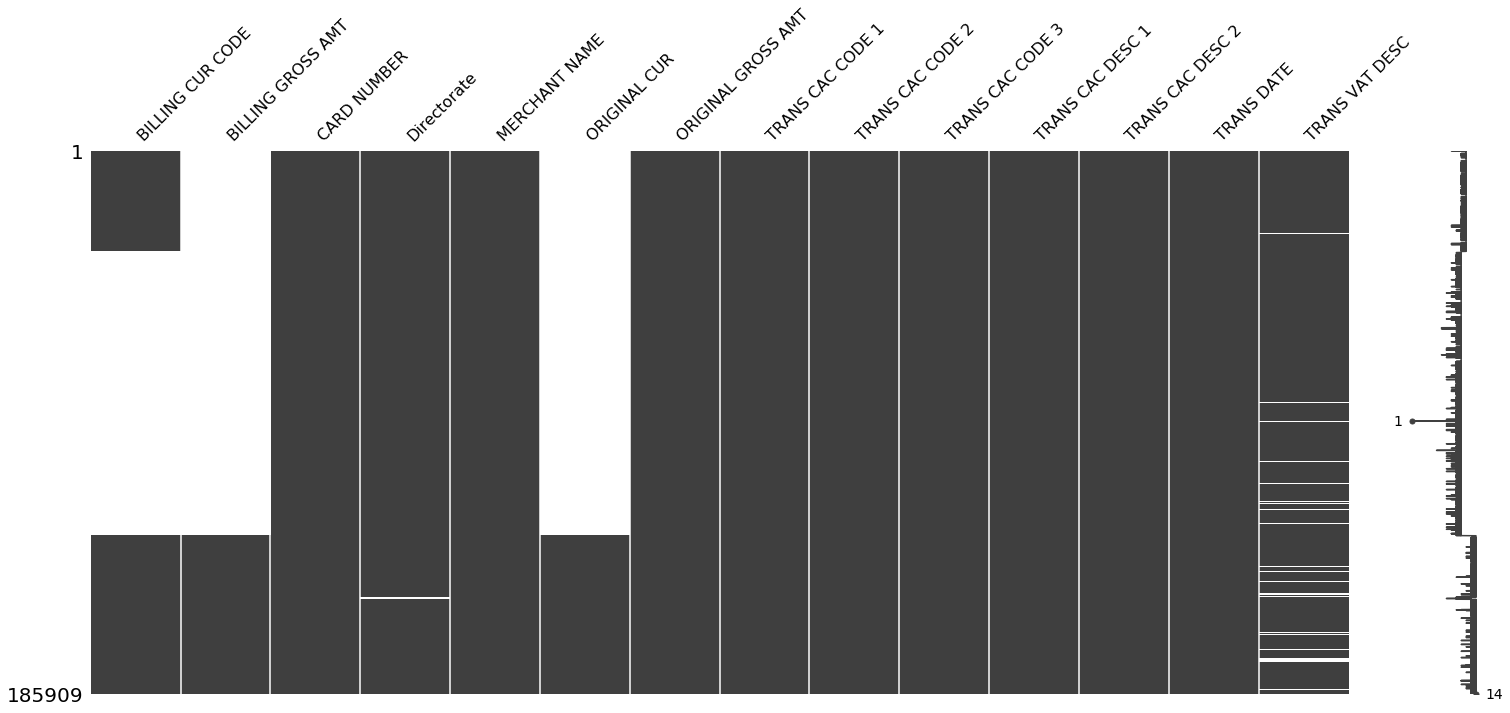

In [48]:
cols_to_drop = ['AGENT',
                 'APPLICANT',
                 'Accepted',
                 'Category',
                 'DEV',
                 'LOCATION',
                 'REFERENCE',
                 'Received_Date',
                 'WARD',
                 'geom', 
                 'Directorate ',
                 'Directorates',
                 'Unnamed: 10',
                 'BILLING CUR CODE.1',
                'TRANS TAX AMT']


def drop_and_group(df):
    print(f'Original shape: {df.shape}')
    df['Directorate'] = df['Directorate'].fillna(df['Directorate '])
    df['Directorate'] = df['Directorate'].fillna(df['Directorates'])
    df['Directorate'] = df['Directorate'].fillna(df['Unnamed: 10'])
    df = df.drop(columns = cols_to_drop)
    df = df.dropna(how='all')
    print(f'Modified shape: {df.shape}')
    return df 


df = drop_and_group(df)
msno.matrix(df)

As we can see we dealt with almost all the null we did not drop the original Cur, billing cur code since we need to explore first the data, determine the date and it could be that we just pick the segment in which those column got data available. 
We will now explore each column from our dataset and get some insights about what we got in each column

#### Univariate exploration
What we want with this piece of code is to answer the following questions about the data: 
* How many unique values are per column?
* Is there any column in which duplicates doesn't make sense?
* How is the central tendency (mean, median, mode) for each numerical variable?
* What are the labels (frequency of each category) composition for each categorical variables? 

In [49]:
df.nunique()

BILLING CUR CODE          1
BILLING GROSS AMT     18904
CARD NUMBER            1523
Directorate              18
MERCHANT NAME         15856
ORIGINAL CUR             19
ORIGINAL GROSS AMT    32612
TRANS CAC CODE 1        143
TRANS CAC CODE 2       1397
TRANS CAC CODE 3         28
TRANS CAC DESC 1        143
TRANS CAC DESC 2       1382
TRANS DATE             1332
TRANS VAT DESC            7
dtype: int64

As we can see from the BILLING CUR CODE just got 1 value, that being said it doesn't add any valuable information. From the rest of variables we got multiple categories which could be worrysome if we want to train a Unsupervised Learning Algorithm 

### Categorical Analysis

In [50]:
df_cat = df.select_dtypes(include='O')

def categorical_report(df):
    for col in df:
        temp = df_cat[col].value_counts(normalize=True)
        temp = temp.reset_index()
        temp['cumsum'] = temp[col].cumsum()
        col_til = temp[temp['cumsum'] > 0.8].iloc[0,:].name+1
        print(f'Total categories in {col}: {df[col].value_counts(normalize=True).shape[0]}')
        print(f'80% reached until {col_til} categories')
        print(df[col].value_counts(normalize=True).apply('{0:.3f}'.format), '\n')
        
categorical_report(df_cat)

Total categories in BILLING CUR CODE: 1
80% reached until 1 categories
GBP    1.000
Name: BILLING CUR CODE, dtype: object 

Total categories in CARD NUMBER: 1523
80% reached until 488 categories
************6308    0.014
************6720    0.012
************6316    0.012
************7710    0.010
************6387    0.007
************8192    0.007
************6034    0.007
************3929    0.006
************8053    0.006
************4035    0.006
************2968    0.005
************5412    0.005
************6740    0.005
************4243    0.005
************1436    0.005
************6158    0.005
************3443    0.004
************4471    0.004
************4244    0.004
************7962    0.004
************5037    0.004
************0276    0.004
************4428    0.004
************2700    0.004
************7784    0.004
************8998    0.004
************9215    0.004
************9391    0.003
************0047    0.003
************1226    0.003
                    ...  

Total categories in TRANS CAC DESC 2: 1382
80% reached until 215 categories
Illegal Money Lending T Stds Comm Inv.      0.075
Homeless Private Sector Accom               0.046
The City of Birmingham School               0.027
Camborne House HLDC                         0.017
Technical Unit                              0.014
Ward End Junior & Infant  (NC)              0.010
West Heath Primary                          0.009
Corp Inbound Post                           0.008
Selly Oak Nursery School                    0.008
Warwick Hse HLDC, 938 Warwick Rd B27        0.008
Uffculme                                    0.008
Raddlebarn Junior & Infant (NC)             0.007
H/Less Temporary Accomdtn Team              0.007
St Barnabas CE Junior & Infant  (NC)        0.007
Colebourne Primary                          0.006
International School & Community College    0.006
Regents Park Junior & Infant (NC)           0.006
Baskerville                                 0.006
Bloomsbury              

From this report we can get an idea about the distribution of the different categories, there are columns with categories that are super granular and it wouldn't make sense to use them. 
Here are the main conclusions:
* CARD NUMBER won't be a feature we will use, there isn't a card that is used more than 1%
* Directorate presents some text issues, then isn't grouping correctly we will fix with some basic string treatment.
* Merchant name is super disperse, we will try just to keep the first piece of the string until the first space trying to maybe group them and reducing the total categories.
* For the ORIGINAL CUR we will use GBP and group all into an Others category.
* We will IN TRANS CAC CODE 1 group all the categories that have less than 5% into others category. 
* We will drop the TRANS CAC CODE 2 column since it's more specific.
* We will use TRANS CAC CODE 3 A00 and group the rest into others category.
* We will drop TRANS CAC DESC 1, TRANS CAC DESC 2 since they're redundant they're in fact the same TRANS CAC CODE [See in source](https://www.whatdotheyknow.com/request/139933/response/342958/attach/5/COST%20CENTRE%20LISTING.csv.txt?cookie_passthrough=1)
* We will in TRANS VAT DESC map from VL onwards to others category.

In [51]:
def categorize_other(serie, threshold):
    temp = serie.value_counts(normalize = True)
    temp = temp[temp > threshold].reset_index()['index'].to_dict()
    temp_dict = {v:v for v in temp.values()}
    serie = serie.map(temp_dict).fillna('Others')
    return serie

def categorical_changes(df):
    threshold = 0.05

    directorate_map = {'cyo&f': 'cyp&f',
                  'adults & communities':'adult & communities',
                  'adults & comms':'adult & communities',}
    
    drop_cat_cols = ['BILLING CUR CODE','CARD NUMBER',
                     'TRANS CAC CODE 2','TRANS CAC DESC 1',
                     'TRANS CAC DESC 2']

                                      
    df['Directorate'] = df['Directorate'].apply(lambda x: str(x).lower().strip())
    df['Directorate'] = df['Directorate'].map(directorate_map).fillna(df['Directorate'])
    df['MERCHANT NAME'] = df['MERCHANT NAME'].apply(lambda x: str(x).split()[0])
    df['ORIGINAL CUR'] = df['ORIGINAL CUR'].apply(lambda x: np.where(x == 'GBP', 'GBP', 'Others'))
    df['TRANS CAC CODE 1'] = categorize_other(df['TRANS CAC CODE 1'], threshold)
    df['TRANS CAC CODE 3'] = categorize_other(df['TRANS CAC CODE 3'],threshold)
    df['TRANS VAT DESC'] = categorize_other(df['TRANS VAT DESC'],threshold)
    df = df.drop(columns = drop_cat_cols)
    return df 

df = categorical_changes(df)

In [52]:
df_cat = df.select_dtypes(include='O')
categorical_report(df_cat)

Total categories in Directorate: 11
80% reached until 3 categories
cyp&f schools                   0.473
local services                  0.228
cyp&f                           0.136
corporate resources             0.067
adult & communities             0.067
development                     0.022
nan                             0.004
adult social care and health    0.003
adults                          0.000
corporate procurement           0.000
                                0.000
Name: Directorate, dtype: object 

Total categories in MERCHANT NAME: 7994
80% reached until 259 categories
amazon                      0.184
travelodge                  0.053
tesco                       0.049
asda                        0.036
paypal                      0.019
sainsburys                  0.018
the                         0.017
shell                       0.015
bp                          0.015
argos                       0.014
post                        0.013
w                           0.012

Merchant name got improved, however is still granular so it won't work for the anomaly detection, then we will also drop the column.

In [55]:
df = df.drop(columns=['MERCHANT NAME'])

### Numerical Analysis

In [63]:
df_numeric = df.select_dtypes(include = 'number')

In [67]:
df_numeric.describe()

BILLING GROSS AMT  ORIGINAL GROSS AMT
count       54229.000000       185908.000000
mean          207.605785          176.607761
std          2369.229937         2133.811542
min       -486980.090000      -486980.090000
25%            13.180000           12.790000
50%            43.000000           40.480000
75%           108.000000           92.230000
max         44433.550000       280102.230000

It appear that the two columns are almost the same we will check if they're different only on the non-null part of BILLING GROSS AMT

In [80]:
temp = df[~df['BILLING GROSS AMT'].isna()]
temp[temp['BILLING GROSS AMT'] != temp['ORIGINAL GROSS AMT']].shape

(317, 8)

In [81]:
fig = px.violin(df, y="ORIGINAL GROSS AMT", box=True, # draw box plot inside the violin
                points='all', # can be 'outliers', or False
               )
fig.show()

There seem to be outliers on the negative side, maybe there are some chargebacks. For now we will leave them and the model should detect specially the big negative one.

In [89]:
df = df.drop(columns ='BILLING GROSS AMT')

In [92]:
df['TRANS DATE'].dt.day_name().value_counts()

Wednesday    37784
Tuesday      37277
Thursday     35483
Monday       32926
Friday       30578
Saturday      6756
Sunday        5104
Name: TRANS DATE, dtype: int64

In [86]:
df['ORIGINAL GROSS AMT'].shape

(185909,)

In [84]:
df[df['ORIGINAL GROSS AMT']>0].shape

(180763, 8)